# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy import stats
from scipy.stats import mstats
import scipy
import statistics
import collections
import math
import random

In [2]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [3]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [4]:
clean_hospital_read_df.shape

(11578, 12)

In [5]:
clean_hospital_read_df.head(5)

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
16857,THREE RIVERS MEDICAL CENTER,180128,KY,READM-30-HIP-KNEE-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
14582,SELLS INDIAN HEALTH SERVICE HOSPITAL,30074,AZ,READM-30-COPD-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15606,PHS INDIAN HOSPITAL AT PINE RIDGE,430081,SD,READM-30-AMI-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15615,FLORIDA STATE HOSPITAL UNIT 31 MED,100298,FL,READM-30-COPD-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
14551,GREENE COUNTY HOSPITAL,10051,AL,READM-30-AMI-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013


In [6]:
clean_hospital_read_df.columns

Index(['Hospital Name', 'Provider Number', 'State', 'Measure Name',
       'Number of Discharges', 'Footnote', 'Excess Readmission Ratio',
       'Predicted Readmission Rate', 'Expected Readmission Rate',
       'Number of Readmissions', 'Start Date', 'End Date'],
      dtype='object')

In [7]:
clean_hospital_read_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11578 entries, 16857 to 13666
Data columns (total 12 columns):
Hospital Name                 11578 non-null object
Provider Number               11578 non-null int64
State                         11578 non-null object
Measure Name                  11578 non-null object
Number of Discharges          11578 non-null int64
Footnote                      81 non-null float64
Excess Readmission Ratio      11497 non-null float64
Predicted Readmission Rate    11497 non-null float64
Expected Readmission Rate     11497 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    11578 non-null object
End Date                      11578 non-null object
dtypes: float64(5), int64(2), object(5)
memory usage: 1.1+ MB


In [8]:
clean_hospital_read_df['Number of Discharges'][81:-3].shape

(11494,)

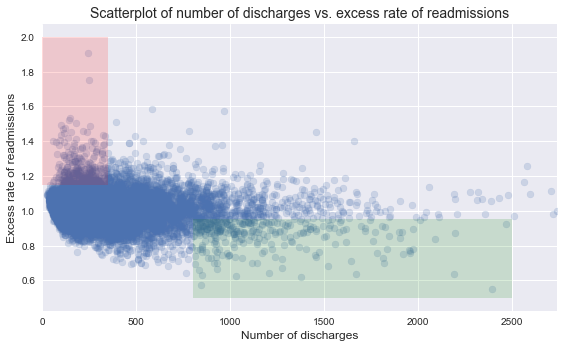

In [9]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
<div class="span5 alert alert-info">
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
</div>
****

## A. Do you agree with the above analysis and recommendations? Why or why not?

From the first look at the scatter plot, it seems that there is actually a slight negative relationship between Number of discharges and Excess Readmission Ratio. Hospital capacity is given as the main reason for # of discharges. Hence the regulatory policy recommendations also looks promising.

However, the amount of statistical analysis is not enough. For instance, there is no sound hypothesis testing done to look at the differences between small and large hospitals. Furthermore, the # of discharge rate may not be related to the size of hospitals. It could very well be due to lack of equipment in the hospitals. 

SO, lets dive in!!

## B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

##### First lets look at a correlation map

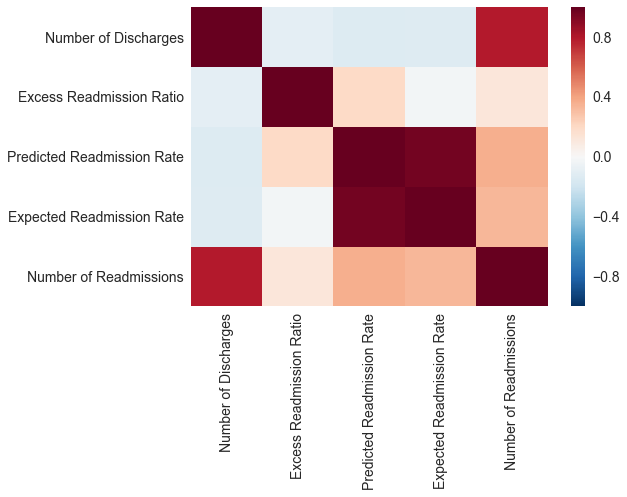

In [10]:
corr = clean_hospital_read_df.drop(['Footnote','Provider Number'], axis=1).corr()
sns.set(font_scale=1.4)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.show()

Looking at the correlation map above, # of Discharges and Excess readmission ratio are only slightly correlated. 

In fact, Excess Readmission Ratio is now well correlated with any other data. The most significant correlations are between Predicted Readmission Rate & Expected Readmission Rate, and # of Readmissions & # of Discharges.

##### Now lets group the data for hypothesis testing

Since the statistics mention hospitals/facilities with number of discharges < 100, < 300 and > 1000, I will divide the data into 3 groups.

First I will see if there is Null data and how many.

In [11]:
clean_hospital_read_df['Excess Readmission Ratio'].isnull().sum()

81

In [12]:
clean_hospital_read_df['Number of Discharges'].isnull().sum()

0

In [13]:
clean_hospital_read_df_notnull = clean_hospital_read_df[(clean_hospital_read_df['Excess Readmission Ratio'].notnull())]
# Low discharge rate hospitals, <100
low_discharge_rate_hospitals = clean_hospital_read_df_notnull[(clean_hospital_read_df_notnull['Number of Discharges'] < 100)]
#  Mid discharge rate hospitals, [100,1000]
mid_discharge_rate_hospitals = clean_hospital_read_df_notnull[(clean_hospital_read_df_notnull['Number of Discharges'] < 1000) & (clean_hospital_read_df_notnull['Number of Discharges'] > 100)]
# High discharge rate hospitals, >1000
high_discharge_rate_hospitals = clean_hospital_read_df_notnull[(clean_hospital_read_df_notnull['Number of Discharges'] > 1000)]

#### Now I want to see if the grouped data is normal. I would use a normality test first. But instead I will start with looking at theoretical and calculated CDF distribution. This will give me a visual idea of the skewness of the data.

In [14]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

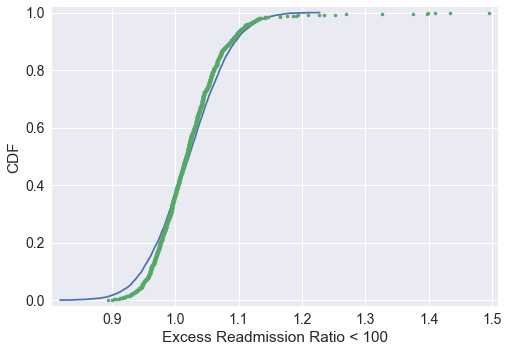

In [15]:
# Compute mean and standard deviation: mu, sigma
mu = np.mean(low_discharge_rate_hospitals['Excess Readmission Ratio'])
sigma = np.std(low_discharge_rate_hospitals['Excess Readmission Ratio'])
# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu,sigma,10000)
# Get the CDF of the samples and of the data
x,y = ecdf(low_discharge_rate_hospitals['Excess Readmission Ratio'])
x_theor,y_theor = ecdf(samples)
# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('Excess Readmission Ratio < 100')
_ = plt.ylabel('CDF')
plt.show()

In [16]:
# k = z-score returned by skewtest and k is the z-score returned by kurtosistest.p= p-value
# we use p value to test if the variable is normal or not

k,p=stats.mstats.normaltest(low_discharge_rate_hospitals['Excess Readmission Ratio']) 

if p<0.05:
  print ('Excess Readmission Ratio < 100 distribution is NOT normal')
else:
  print ('Excess Readmission Ratio < 100 distribution is normal')

Excess Readmission Ratio < 100 distribution is NOT normal


In [17]:
ks_results = scipy.stats.kstest(low_discharge_rate_hospitals['Excess Readmission Ratio'], cdf='norm')
print(ks_results)
if ks_results[1]<0.05:
  print ('Excess Readmission Ratio < 100 distribution is NOT normal')
else:
  print ('Excess Readmission Ratio < 100 distribution is normal')

KstestResult(statistic=0.81541725367361129, pvalue=0.0)
Excess Readmission Ratio < 100 distribution is NOT normal


#### Lets check the normality for other groups, [100,1000] and >1000 group

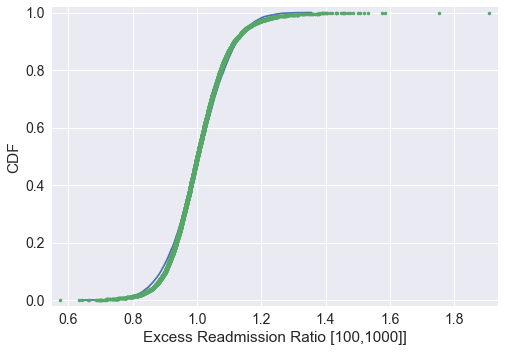

In [18]:
# Compute mean and standard deviation: mu, sigma
mu = np.mean(mid_discharge_rate_hospitals['Excess Readmission Ratio'])
sigma = np.std(mid_discharge_rate_hospitals['Excess Readmission Ratio'])
# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu,sigma,10000)
# Get the CDF of the samples and of the data
x,y = ecdf(mid_discharge_rate_hospitals['Excess Readmission Ratio'])
x_theor,y_theor = ecdf(samples)
# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('Excess Readmission Ratio [100,1000]]')
_ = plt.ylabel('CDF')
plt.show()

This looks more promising for Normal distribution. Lets use Kolmogoroc-Smirnov test again.

In [19]:
ks_results = scipy.stats.kstest(mid_discharge_rate_hospitals['Excess Readmission Ratio'], cdf='norm')
print(ks_results)
if ks_results[1]<0.05:
  print ('Excess Readmission Ratio [100,1000] distribution is NOT normal')
else:
  print ('Excess Readmission Ratio [100,1000] distribution is normal')

KstestResult(statistic=0.77770591091876728, pvalue=0.0)
Excess Readmission Ratio [100,1000] distribution is NOT normal


#### I am not going to plot CDF for >1000 group. Instead I will perform normality test.

In [20]:
ks_results = scipy.stats.kstest(high_discharge_rate_hospitals['Excess Readmission Ratio'], cdf='norm')
print(ks_results)
if ks_results[1]<0.05:
  print ('Excess Readmission Ratio >1000 distribution is NOT normal')
else:
  print ('Excess Readmission Ratio >1000 distribution is normal')

KstestResult(statistic=0.74035161531314264, pvalue=0.0)
Excess Readmission Ratio >1000 distribution is NOT normal


##### One more visualization is histogram representation of data. But they all look on top of each other

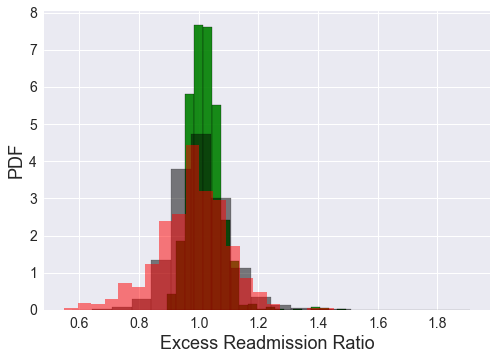

In [21]:
plt.hist(sorted(low_discharge_rate_hospitals['Excess Readmission Ratio']), 20, normed=True, facecolor='green', alpha=0.9, edgecolor = "black")

plt.hist(sorted(mid_discharge_rate_hospitals['Excess Readmission Ratio']), 20, normed=True, facecolor='black', alpha=0.5, edgecolor = "black")

plt.hist(sorted(high_discharge_rate_hospitals['Excess Readmission Ratio']), 20, normed=True, facecolor='red', alpha=0.5)

plt.xlabel('Excess Readmission Ratio', fontsize=18)
plt.ylabel('PDF', fontsize=18)

plt.show()

### No group seems to have normal distribution. 

Although n > 30 and non-normality should not be an issue for t-test, I will try another method: Kruskal-Wallis test, which is a non-parametric and distribution free test. 

Null hypothesis: Assumes that the samples are from identical populations.

Alternative hypothesis: Assumes that at least one of the samples (groups) comes from a different population than the others.

In [22]:
H, pval = mstats.kruskalwallis(low_discharge_rate_hospitals['Excess Readmission Ratio'], mid_discharge_rate_hospitals['Excess Readmission Ratio'], high_discharge_rate_hospitals['Excess Readmission Ratio'])

print("h-statistic:", H)
print("p-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

h-statistic: 84.8512801145
p-Value: 3.75645881706e-19
Reject NULL hypothesis - Significant differences exist between groups.


These results tell us that the difference in Excess Readmission Ratios between low, mid, and high_discharge hospitals is significant and not due solely to chance. 

## 3. Report statistical significance for  α  = 0.01

When a p-value is less than or equal to the significance level (0.01), we reject the NULL hypothesis.

In our case, p-value is much smaller than α. The result obtained from Kruskal-Wallis test is not completely due to chance. 

## 4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?

By definition, excess readmissions are measured by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. Assuming that # of discharges are definitely related to the hospital size, and not the quality of care, our findings support the recommendation made to the client smaller hospitals should obtain necessary resources to ensure quality care and prevent complications. 

We found that there is a significant statistical difference between separated groups (<100, [100,1000], >1000). 

Practically, however, I would be cautious and collect more data on the same dataset. For instance, I would find the patient care time, severity of admissions, and average age of patients. Then I would make more sound recommendation.